In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import rasterio as rio

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy
import itertools
import random
import ast

## Data prep

In [2]:
def img_to_df(img_path, cols):
    with rio.open(img_path) as src:
        as_array = src.read()
        band_arrs = []
        
        for i in np.arange(src.count):
            band_arr = as_array[i].flatten()
            band_arr = band_arr/10000
            
            band_arrs.append(band_arr)
        
        df = pd.DataFrame(band_arrs,cols).T
        df['Date'] = img_path.split('/')[-1].split('_')[0]
        
        # Optional: drops entries with no severity rating. Comment out if unnecessary.
        no_nans = df.dropna(subset=['total_dis_sev']) 
        
        return no_nans

In [3]:
def add_vis(df):
    df['pri']= (df['green']- df['greenI'])/(df['green']+df['greenI'])
    df['ndre'] = (df['nir'] - df['rede']) / (df['nir'] + df['rede'])
    df['tcari'] = 3 * (( (df['rede'] - df['red']) - 0.2 * (df['rede'] - df['green']) ) * (df['rede'] / df['red']))
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    df['grvi'] = (df['green']-df['red'])/(df['green']+df['red'])

    return df

In [4]:
data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'
dis_ras_20 = glob.glob(data_dir +'images/2020/PScope/dis_band_*/20*.tif')
dis_ras_21 = glob.glob(data_dir +'images/2021/PScope/dis_band_*/20*.tif')
dis_ras_22 = glob.glob(data_dir +'images/2022/PScope/dis_band_*/20*.tif')

In [5]:
# Get dataframes for all years
def data_prep_ps(rasters, cols):
    dfs = [img_to_df(rasters[i], cols) for i in np.arange(len(rasters))]
    df = pd.concat(dfs)
    df['total_dis_sev'] = df['total_dis_sev']*10000
    df['dm_sev'] = df['dm_sev']*10000
    df['dm_inc'] = df['dm_inc']*10000
    df['inc_class'] = 0
    df.loc[df['dm_inc']>25,'inc_class']= 1
    df['severity_class'] = 0
    df.loc[df['dm_sev']>10,'severity_class']= 1
    vis = add_vis(df)
    return vis
    
    
# dfs_2020 = [img_to_df(dis_ras_20[i], cols) for i in np.arange(len(dis_ras_20))]
# df_2020 = pd.concat(dfs_2020)

# df_2020['total_dis_sev'] = df_2020['total_dis_sev']*10000
# df_2020['dm_sev'] = df_2020['dm_sev']*10000
# df_2020['dm_inc'] = df_2020['dm_inc']*10000

# df_2020['inc_class'] = 'low'
# df_2020.loc[df_2020['dm_inc']>25,'inc_class']= 'high'
    
# df_2020['severity_class'] = 'low'
# df_2020.loc[df_2020['dm_sev']>10,'severity_class']= 'high'

# vis_2020 = add_vis(df_2020)

# vis_2020.columns

In [6]:
cols = ['c_blue','blue','greenI', 'green', 'yellow', 'red', 'rede', 'nir','total_dis_sev','dm_sev', 'dm_inc']
vi_dfs = []

for ras in [dis_ras_20, dis_ras_21, dis_ras_22]:
    vi_df = data_prep_ps(ras,cols)
    vi_dfs.append(vi_df)
    
len(vi_dfs)

3

In [7]:
vi_dfs[2].Date.unique()

array(['20220726', '20220801', '20220630', '20220704', '20220624'],
      dtype=object)

In [8]:
for date in (vi_dfs[2].Date.unique()):
    print(date[:4])

2022
2022
2022
2022
2022


In [9]:
vi_dfs[0].columns

Index(['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir',
       'total_dis_sev', 'dm_sev', 'dm_inc', 'Date', 'inc_class',
       'severity_class', 'pri', 'ndre', 'tcari', 'ndvi', 'evi', 'savi', 'arvi',
       'grvi'],
      dtype='object')

In [10]:
# set up variables
data_2022 = vi_dfs[2]
data_2021 = vi_dfs[1]
data_2020 = vi_dfs[0]
data_all = pd.concat([data_2020,data_2021,data_2022])
sev = 'severity_class'
inc = 'inc_class'
#sbs = ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir']
vis = ['pri', 'ndre', 'tcari', 'ndvi', 'evi', 'savi', 'arvi',
       'grvi']

## Find best set of VIs

In [11]:
def get_combinations(lst): # creating a user-defined method
    combination = [] # empty list 
    for r in range(1, len(lst) + 1):
      # to generate combination
      combination += itertools.combinations(lst, r)
    return combination

In [12]:
all_combinations = get_combinations(vis) # method call
print(all_combinations)

[('pri',), ('ndre',), ('tcari',), ('ndvi',), ('evi',), ('savi',), ('arvi',), ('grvi',), ('pri', 'ndre'), ('pri', 'tcari'), ('pri', 'ndvi'), ('pri', 'evi'), ('pri', 'savi'), ('pri', 'arvi'), ('pri', 'grvi'), ('ndre', 'tcari'), ('ndre', 'ndvi'), ('ndre', 'evi'), ('ndre', 'savi'), ('ndre', 'arvi'), ('ndre', 'grvi'), ('tcari', 'ndvi'), ('tcari', 'evi'), ('tcari', 'savi'), ('tcari', 'arvi'), ('tcari', 'grvi'), ('ndvi', 'evi'), ('ndvi', 'savi'), ('ndvi', 'arvi'), ('ndvi', 'grvi'), ('evi', 'savi'), ('evi', 'arvi'), ('evi', 'grvi'), ('savi', 'arvi'), ('savi', 'grvi'), ('arvi', 'grvi'), ('pri', 'ndre', 'tcari'), ('pri', 'ndre', 'ndvi'), ('pri', 'ndre', 'evi'), ('pri', 'ndre', 'savi'), ('pri', 'ndre', 'arvi'), ('pri', 'ndre', 'grvi'), ('pri', 'tcari', 'ndvi'), ('pri', 'tcari', 'evi'), ('pri', 'tcari', 'savi'), ('pri', 'tcari', 'arvi'), ('pri', 'tcari', 'grvi'), ('pri', 'ndvi', 'evi'), ('pri', 'ndvi', 'savi'), ('pri', 'ndvi', 'arvi'), ('pri', 'ndvi', 'grvi'), ('pri', 'evi', 'savi'), ('pri', 'evi'

In [13]:
# Append all possible combinations of vis to the spectral bands
# Result = list of potential explanatory variables

exp_vars = []
for combo in all_combinations:
    combo = list(combo)
    sb = ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir']
    sb_plus_vi = sb + combo
    exp_vars.append(sb_plus_vi)
#exp_vars

In [14]:
# Prep the dataset: balance the data and scale
## no need to split into train/test

def data_prep(data, expl_vars, resp_var, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    mm = MinMaxScaler()
    X_scaled = mm.fit_transform(X_rus)
    
    return X_scaled, y_rus #features (scaled) and labels (unscaled)

In [15]:
# Get a dictionary of models for each set of explanatory variables

def get_models(explanatory_vars):
    models = dict()
    for i in exp_vars:
        model = RandomForestClassifier()
        models[str(i)] = model
    return models

In [16]:
# evaluate a given model using cross-validation

def evaluate_model(model, X, y,scoring):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) # will get 30 (10x3) different results
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [19]:
def F1_df(df, models, resp_var):
    results = pd.DataFrame(columns=['name','F1', 'features'])
    F1 = []
    features = []
    year = []
    for name, model in models.items():
        X,y = data_prep(df,ast.literal_eval(name),resp_var,2024,16)
        scores = evaluate_model(model, X, y,'f1')
        F1.append(np.mean(scores))
        features.append(name)
        year.append(df.Date.unique()[0][:4])

    results['name'] = year
    results['F1']=F1
    results['features']=features
    
    return results

In [20]:
# get dataframes of average F1 scores for models with different combinations of explanatory variables
models = get_models(exp_vars)

F1_dfs = []

for df in [data_2020, data_2021, data_2022]:
    F1_scores = F1_df(df, models, inc)
    F1_dfs.append(F1_scores)

len(F1_dfs)

3

In [23]:
F1_dfs[2]

name        F1                                           features
0    2022  0.831083  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
1    2022  0.813915  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
2    2022  0.812679  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
3    2022  0.808824  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
4    2022  0.807870  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
..    ...       ...                                                ...
250  2022  0.817173  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
251  2022  0.814889  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
252  2022  0.811088  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
253  2022  0.807344  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
254  2022  0.809186  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...

[255 rows x 3 columns]

In [24]:
# best vi combos for each year (maximizes F1)
combo_20 = F1_dfs[0].iloc[F1_dfs[0]['F1'].idxmax()]['features']
print("Best feature combo for 2020:", combo_20)

combo_21 = F1_dfs[1].iloc[F1_dfs[1]['F1'].idxmax()]['features']
print("Best feature combo for 2021:", combo_21)

combo_22 = F1_dfs[2].iloc[F1_dfs[2]['F1'].idxmax()]['features']
print("Best feature combo for 2022:", combo_22)

Best feature combo for 2020: ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir', 'ndvi', 'savi', 'arvi']
Best feature combo for 2021: ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir', 'pri', 'ndre', 'evi', 'savi', 'arvi']
Best feature combo for 2022: ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir', 'pri']


## Balance, split, normalize

In [25]:
def bal_split_norm(data, expl_vars, resp_var, state, seed):
    X = data[expl_vars]
    y = data[resp_var]

    rus = RandomUnderSampler(random_state=state)
    X_rus, y_rus = rus.fit_resample(X, y)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                        test_size=0.3, 
                                                        random_state=seed,
                                                        stratify = y_rus)  # 70% training and 30% test
    mm = MinMaxScaler()
    X_train_scaled = mm.fit_transform(X_train)
    X_test_scaled = mm.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

## For 2020

In [27]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2020,
#                                                   ast.literal_eval(combo_20), #convert string to list
#                                                  inc,
#                                                  2020,
#                                                  14)

## Hyperparameter tuning (training set only)

In [28]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [29]:
# rfc = RandomForestClassifier()

In [30]:
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 18,
 'min_samples_leaf': 25,
 'max_features': 'sqrt',
 'max_depth': 3,
 'bootstrap': True}

In [31]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                300                      18                     25   
1                300                      18                     37   
2                100                      34                      1   
3                600                       2                     13   
4                300                      28                     25   
5                900                      34                     37   
6                900                      39                     37   
7                300                      12                     13   
8                400                      12                     25   
9                600                      23                     50   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               sqrt               3            True         0.954178   
1               log2              11           False         0.954178   
2               sqrt               4            True         0.954178   
3               sqrt               9           False         0.954178   
4               sqrt              12           False         0.954178   
5               log2              11            True         0.954178   
6               log2              11           False         0.954178   
7               log2              12            True         0.954178   
8               sqrt              12            True         0.954178   
9               sqrt              14           False         0.954178   

   rank_test_score  
0                1  
1                1  
2                1  
3                1  
4                1  
5                1  
6                1  
7                1  
8                1  
9                1

In [32]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,300,600]
# max_features = ['sqrt','log2']
# max_depth = [3,4,9,11]
# min_samples_split = [2,18,28,34]
# min_samples_leaf = [1,25,37,13]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 28,
 'n_estimators': 600}

In [33]:
# y_pred_gs = rfc_2.predict(X_test)

## Plot confusion matrix and get all model metrics

[[52 10]
 [ 0 63]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        62
           1       0.86      1.00      0.93        63

    accuracy                           0.92       125
   macro avg       0.93      0.92      0.92       125
weighted avg       0.93      0.92      0.92       125



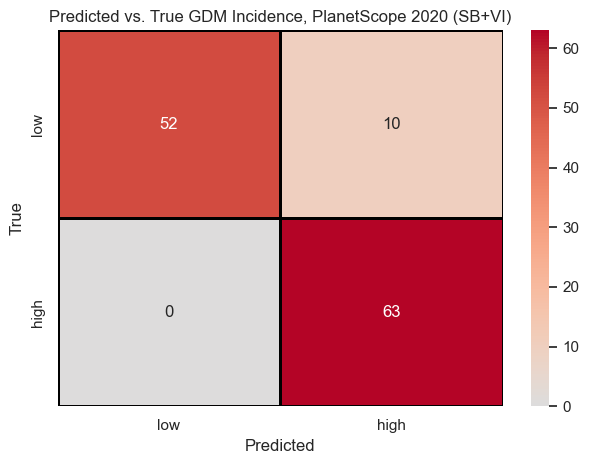

In [34]:
# from sklearn.metrics import confusion_matrix                            



# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True,
#            vmin=0, vmax=63, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black',
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM Incidence, PlanetScope 2020 (SB+VI)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB+VI/Inc_2020.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

In [83]:
# # Make sure axes are properly labeled
# unique, counts = np.unique(y_pred_gs, return_counts=True)

# dict(zip(unique, counts))

{0: 28, 1: 43}

## Permutation importance plots

In [84]:
# Get permutation feature imp. scores
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

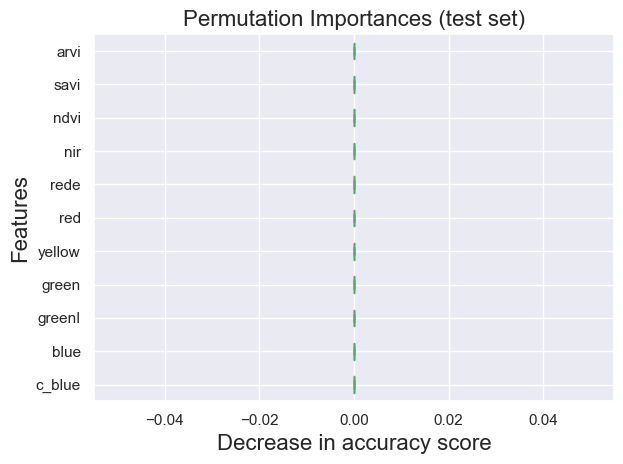

In [35]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2020[ast.literal_eval(combo_20)].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB+VI/permimp_inc20.jpg')

## 2021

In [36]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2021,
#                                                   ast.literal_eval(combo_21),
#                                                  inc,
#                                                  2020,
#                                                  14)

In [37]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [38]:
# rfc = RandomForestClassifier()
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 28,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 8,
 'bootstrap': False}

In [39]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                700                      28                      1   
1                300                      12                      1   
2                300                      18                      1   
3                700                       2                      1   
4                400                      23                      1   
5                200                      12                      1   
6                700                      18                      1   
7                100                      50                     13   
8                200                      39                      1   
9                900                      23                     13   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               sqrt               8           False         0.908469   
1               log2              13           False         0.908139   
2               sqrt              12           False         0.907826   
3               log2               6           False         0.907348   
4               log2               5           False         0.907178   
5               log2               7            True         0.905773   
6               log2               7            True         0.905008   
7               sqrt              13           False         0.904864   
8               log2               9           False         0.904815   
9               sqrt               5           False         0.904447   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

In [40]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,300,700]
# max_features = ['sqrt','log2']
# max_depth = [6,8,12,13]
# min_samples_split = [2,12,18,28]
# min_samples_leaf = [1]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 192 candidates, totalling 576 fits


{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 700}

In [41]:
# y_pred_gs = rfc_2.predict(X_test)

[[240  18]
 [ 29 229]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       258
           1       0.93      0.89      0.91       258

    accuracy                           0.91       516
   macro avg       0.91      0.91      0.91       516
weighted avg       0.91      0.91      0.91       516



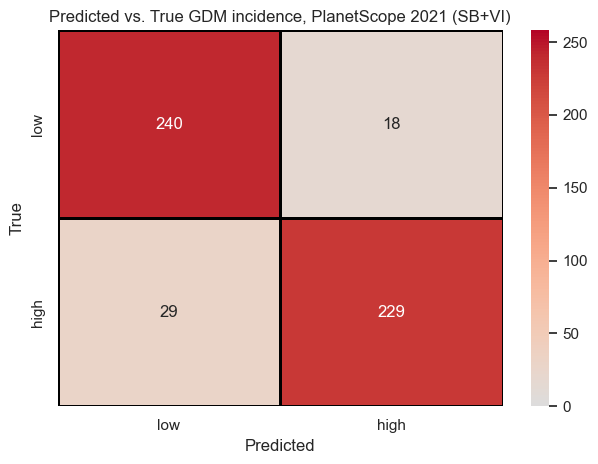

In [42]:
# from sklearn.metrics import confusion_matrix                            


# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True, fmt='.3g',
#            vmin=0, vmax=258, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black',
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM incidence, PlanetScope 2021 (SB+VI)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB+VI/Inc_2021.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

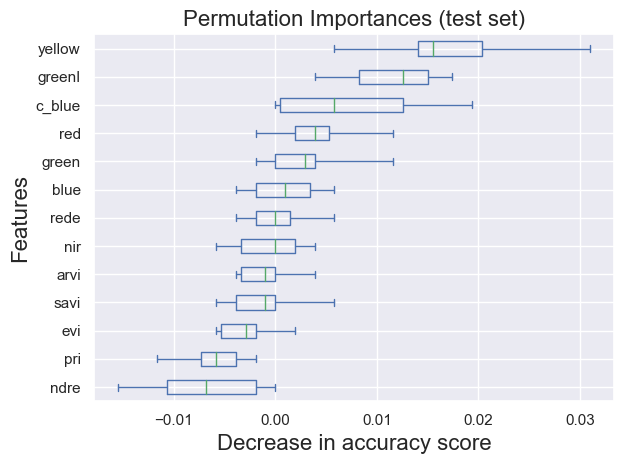

In [43]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2021[ast.literal_eval(combo_21)].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB+VI/permimp_inc21.jpg')

## 2022

In [44]:
# X_train, y_train, X_test, y_test = bal_split_norm(data_2022,
#                                                   ast.literal_eval(combo_22), #convert string to list
#                                                  inc,
#                                                  2020,
#                                                  14)

In [45]:
# # Create dictionary of parameters to test with randomizedCV

# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
# num = 5)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [46]:
# rfc = RandomForestClassifier()
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# scoring = 'f1',
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train, y_train)
# rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 7,
 'bootstrap': True}

In [47]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                700                      18                      1   
1                200                      12                      1   
2                300                      12                      1   
3                400                      23                      1   
4                200                      39                      1   
5                700                       2                      1   
6                300                      18                      1   
7                700                      28                      1   
8                600                      12                      1   
9                800                      23                     13   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               log2               7            True         0.804477   
1               log2               7            True         0.797163   
2               log2              13           False         0.797083   
3               log2               5           False         0.796249   
4               sqrt               6           False         0.795944   
5               log2               6           False         0.794269   
6               sqrt              12           False         0.793854   
7               sqrt               8           False         0.788467   
8               log2               4           False         0.788169   
9               sqrt              14           False         0.785207   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

In [48]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100, 200,300,400,700]
# max_features = ['sqrt','log2']
# max_depth = [3,5,6,7,13]
# min_samples_split = [2,12,18,23]
# min_samples_leaf = [1]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


{'bootstrap': True,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [49]:
# y_pred_gs = rfc_2.predict(X_test)

[[49  9]
 [12 46]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        58
           1       0.84      0.79      0.81        58

    accuracy                           0.82       116
   macro avg       0.82      0.82      0.82       116
weighted avg       0.82      0.82      0.82       116



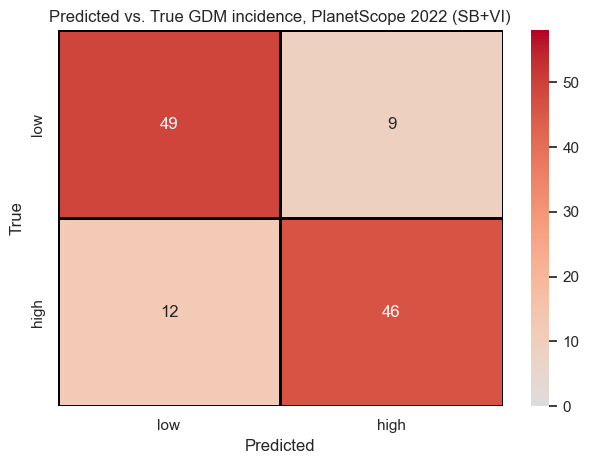

In [50]:
# from sklearn.metrics import confusion_matrix                            


# cf_matrix = confusion_matrix(y_test, y_pred_gs)
# print(cf_matrix)

# sns.set(font_scale=1)
# sns.heatmap(cf_matrix, annot=True, fmt='.3g',
#            vmin=0, vmax=58, center= 0,
#            cmap= 'coolwarm', linewidths=2, linecolor='black', 
#            #cbar_kws={'ticks':[0,1,2,3]},
#            xticklabels=['low','high'],
#            yticklabels=['low','high']).set(title='Predicted vs. True GDM incidence, PlanetScope 2022 (SB+VI)');

# plt.ylabel('True')
# plt.xlabel('Predicted')
# plt.tight_layout()

# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB+VI/Inc_2022.jpg')
# report = classification_report(y_test, y_pred_gs)

# print(report)
# # conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
# #         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# # display(conf_matrix_tuned)
# # display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

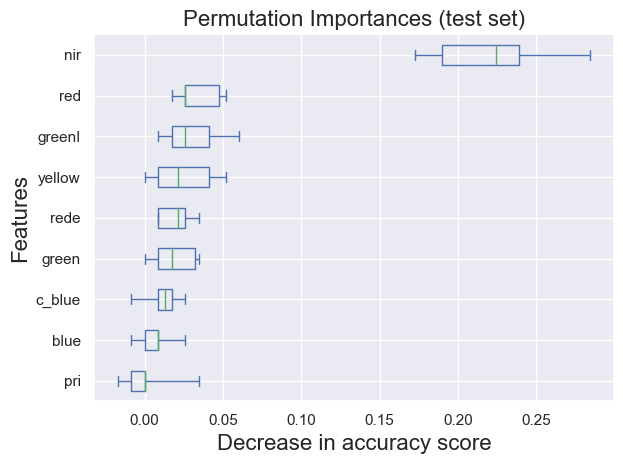

In [51]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
# )

# sorted_importances_idx = result.importances_mean.argsort()

# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=data_2022[ast.literal_eval(combo_22)].columns[sorted_importances_idx],
# )
# ax = importances.plot.box(vert=False, whis=10)
# ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
# #ax.axvline(x=0, color="k", linestyle="--")
# ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
# ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

# ax.figure.tight_layout()
# plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB+VI/permimp_inc22.jpg')

## All years

In [52]:
# get F1 scores for different VI combos

models = get_models(exp_vars)

F1_allyear = pd.DataFrame(columns=['F1', 'features'])
F1 = []
features = []

for name, model in models.items():
        X,y = data_prep(data_all,ast.literal_eval(name),inc,2024,16)
        scores = evaluate_model(model, X, y,'f1')
        F1.append(np.mean(scores))
        features.append(name)
F1_allyear['F1']=F1
F1_allyear['features']=features

F1_allyear

F1                                           features
0    0.891215  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
1    0.887728  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
2    0.891439  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
3    0.892686  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
4    0.890735  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
..        ...                                                ...
250  0.893170  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
251  0.895701  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
252  0.895399  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
253  0.892610  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...
254  0.893700  ['c_blue', 'blue', 'greenI', 'green', 'yellow'...

[255 rows x 2 columns]

In [53]:
# find VI combo that maximizes F1

combo_all = F1_allyear.iloc[F1_allyear['F1'].idxmax()]['features']
print("Best feature combo for all-year:", combo_all)

Best feature combo for all-year: ['c_blue', 'blue', 'greenI', 'green', 'yellow', 'red', 'rede', 'nir', 'pri', 'ndre', 'tcari', 'ndvi', 'evi', 'savi']


In [54]:
X_train, y_train, X_test, y_test = bal_split_norm(data_all,
                                                  ast.literal_eval(combo_all), #convert string to list
                                                 inc,
                                                 2020,
                                                 14)

In [55]:
# Create dictionary of parameters to test with randomizedCV

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 50,
num = 5)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [56]:
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc,
param_dist,
n_iter = 100,
scoring = 'f1',
cv = 3,
verbose = 1,
n_jobs=-1,
random_state=0)

rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': False}

In [57]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
'mean_fit_time',
'std_fit_time',
'mean_score_time',
'std_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'std_test_score'],
axis=1)

rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                300                      18                      1   
1                300                      12                      1   
2                300                      34                      1   
3                200                      12                      1   
4                300                      12                     13   
5                400                      12                     13   
6                700                      18                      1   
7                800                      12                     13   
8                700                       2                      1   
9                300                      28                     13   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               sqrt              12           False         0.890977   
1               log2              13           False         0.890432   
2               log2              14            True         0.886895   
3               log2               7            True         0.886794   
4               sqrt               9            True         0.886575   
5               log2              14            True         0.886541   
6               log2               7            True         0.886122   
7               sqrt              15            True         0.885897   
8               log2               6           False         0.885711   
9               log2              10           False         0.885656   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

In [58]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100,200,300]
max_features = ['sqrt','log2']
max_depth = [3,7,9,12,13,14]
min_samples_split = [2,12,18,34]
min_samples_leaf = [1,13]
bootstrap = [True,False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_2 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


{'bootstrap': True,
 'max_depth': 13,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [59]:
y_pred_gs = rfc_2.predict(X_test)

[[342  36]
 [ 49 329]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       378
           1       0.90      0.87      0.89       378

    accuracy                           0.89       756
   macro avg       0.89      0.89      0.89       756
weighted avg       0.89      0.89      0.89       756



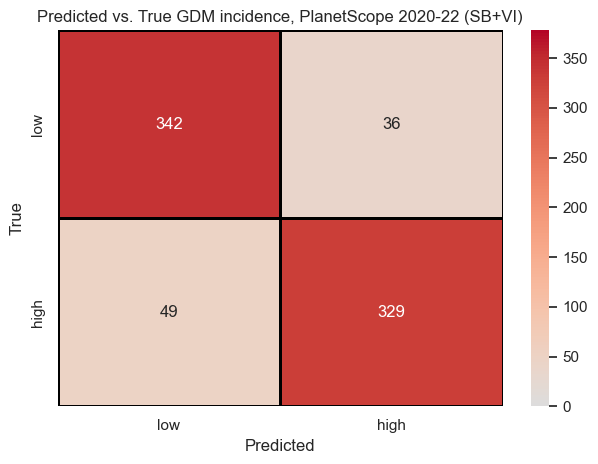

In [60]:
from sklearn.metrics import confusion_matrix                            


cf_matrix = confusion_matrix(y_test, y_pred_gs)
print(cf_matrix)

sns.set(font_scale=1)
sns.heatmap(cf_matrix, annot=True, fmt='.3g',
           vmin=0, vmax=378, center= 0,
           cmap= 'coolwarm', linewidths=2, linecolor='black',
           xticklabels=['low','high'],
           yticklabels=['low','high']).set(title='Predicted vs. True GDM incidence, PlanetScope 2020-22 (SB+VI)');

plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()

plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/corr_matrices_RF/PScope/SB+VI/Inc_all.jpg')
report = classification_report(y_test, y_pred_gs)

print(report)
# conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
#         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# display(conf_matrix_tuned)
# display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

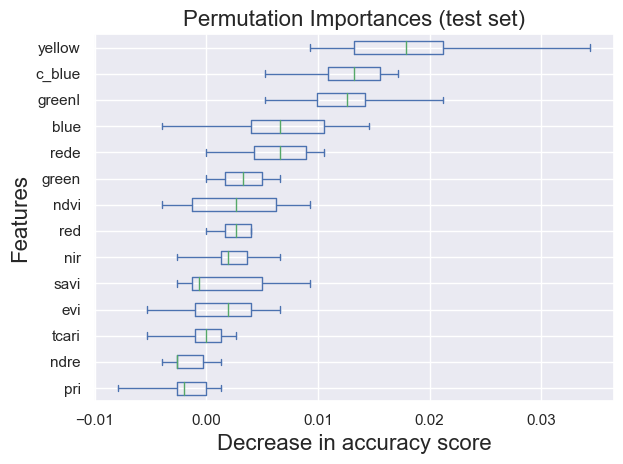

In [61]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc_2, X_test, y_test, n_repeats=10, random_state=16, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data_all[ast.literal_eval(combo_all)].columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)",fontname="Arial", fontsize=16)
#ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 16)
ax.set_ylabel("Features",fontname="Arial", fontsize = 16)

ax.figure.tight_layout()
plt.savefig('/Users/kathleenkanaley/Desktop/figs_phytopath_rev/permimp_RF/PScope/SB+VI/permimp_incall.jpg')